In [1]:
from non_local_detector.simulate.sorted_spikes_simulation import make_simulated_data

(
    speed,
    position,
    spike_times,
    time,
    event_times,
    sampling_frequency,
    is_event,
    place_fields,
) = make_simulated_data()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/likelihoods/clusterless_kde.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from non_local_detector import NonLocalSortedSpikesDetector
import numpy as np

detector = NonLocalSortedSpikesDetector()

position = position[:, np.newaxis] if position.ndim == 1 else position
detector.fit(time, position, spike_times, is_training=~is_event)

Encoding models:   0%|          | 0/25 [00:00<?, ?cell/s]

NonLocalSortedSpikesDetector(continuous_initial_conditions_types=[UniformInitialConditions(),
                                                                  UniformInitialConditions(),
                                                                  UniformInitialConditions(),
                                                                  UniformInitialConditions()],
                             continuous_transition_types=[[<non_local_detector.continuous_state_transitions.Discrete object at 0x164a5bf90>,
                                                           <non_local_detector.continuous_state_transitions.Discrete object at 0x...
                                                                  encoding_group=0,
                                                                  is_local=False,
                                                                  is_no_spike=False),
                                                 ObservationModel(environment_name='',
                                                                  encoding_group=0,
                                                                  is_local=False,
                                                                  is_no_spike=False)],
                             sampling_frequency=500.0,
                             sorted_spikes_algorithm='sorted_spikes_kde',
                             sorted_spikes_algorithm_params={'block_size': 10000,
                                                             'position_std': 6.0},
                             state_names=['Local', 'No-Spike',
                                          'Non-Local Continuous',
                                          'Non-Local Fragmented'])

## Linear regression

step 0, loss: 9.985331535339355
step 100, loss: 1.0518211126327515
step 200, loss: 0.9960808157920837
step 300, loss: 0.9960803389549255
step 400, loss: 0.996080219745636


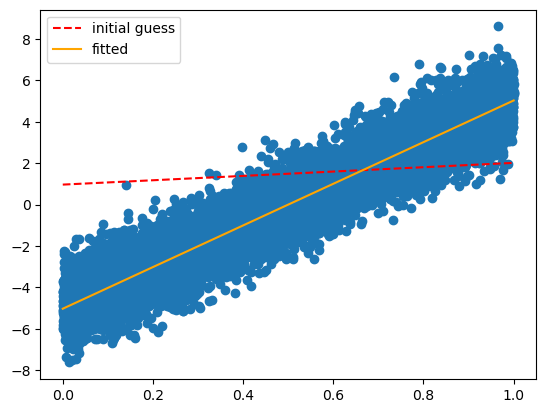

In [3]:
import jax
import jax.numpy as jnp
import optax
import numpy as np
from typing import Tuple
from collections.abc import Callable
import matplotlib.pyplot as plt


def fit(
    params: optax.Params,
    optimizer: optax.GradientTransformation,
    loss: Callable,
    design_matrix: jnp.ndarray,
    response: jnp.ndarray,
    n_iters: int = 50,
) -> optax.Params:

    # @jax.jit
    def step(
        params: optax.Params, opt_state: optax.OptState
    ) -> Tuple[optax.Params, optax.OptState, float]:
        loss_value, grads = jax.value_and_grad(loss)(params, design_matrix, response)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    opt_state = optimizer.init(params)
    for i in range(n_iters):
        params, opt_state, loss_value = step(params, opt_state)
        if i % 100 == 0:
            print(f"step {i}, loss: {loss_value}")

    return params


def loss(
    params: optax.Params, design_matrix: jnp.ndarray, response: jnp.ndarray
) -> float:
    predictions = design_matrix @ params
    return jnp.mean(
        optax.losses.squared_error(predictions=predictions, targets=response)
    )


x = np.linspace(0, 1, 10_000)
response = -5 + 10 * x + np.random.randn(len(x))
design_matrix = np.c_[np.ones_like(x), x]
params = np.random.randn(2)

plt.scatter(x, response)
plt.plot(x, design_matrix @ params, color="red", linestyle="--", label="initial guess")

optimizer = optax.adam(learning_rate=1e-1)
params = fit(params, optimizer, loss, design_matrix, response, n_iters=500)
plt.plot(x, design_matrix @ params, color="orange", label="fitted")
plt.legend()

## Poisson Regression

step 0, loss: 1.020920991897583
step 100, loss: 0.0024438672699034214


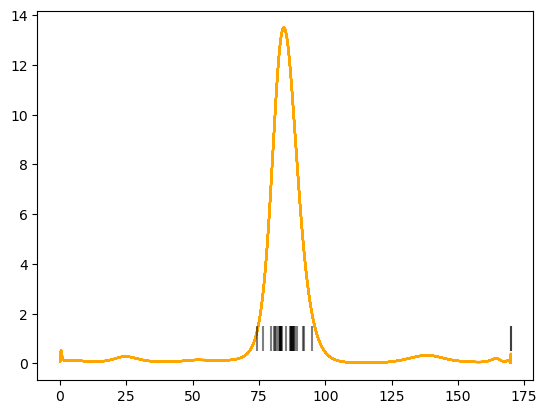

In [4]:
from non_local_detector.likelihoods.common import get_spikecount_per_time_bin
import patsy

EPS = 1e-6


def loss(
    params: optax.Params, design_matrix: jnp.ndarray, response: jnp.ndarray
) -> float:
    conditional_intensity = jnp.exp(design_matrix @ params)
    return -1.0 * jnp.mean(
        jax.scipy.stats.poisson.logpmf(response, conditional_intensity + EPS)
    )


cell_ind = 12
optimizer = optax.adam(learning_rate=1)
response = get_spikecount_per_time_bin(spike_times[cell_ind], time)
design_matrix = patsy.dmatrix(
    "bs(position, df=35, include_intercept=True) - 1", data={"position": position}
)
params = np.random.randn(design_matrix.shape[1])

params = fit(params, optimizer, loss, design_matrix, response, n_iters=200)

plt.plot(
    position,
    jnp.exp(design_matrix @ params) * sampling_frequency,
    color="orange",
    label="fitted",
)
plt.eventplot([position[response.astype(bool)].squeeze()], color="black", alpha=0.5)

In [5]:
import jax.random as jr


def loss_for_single_neuron(params, design_matrix, response):
    conditional_intensity = jnp.exp(design_matrix @ params)
    return -1.0 * jnp.mean(
        jax.scipy.stats.poisson.logpmf(response, conditional_intensity + EPS)
    )


def step(
    params: optax.Params,
    opt_state: optax.OptState,
    optimizer: optax.GradientTransformation,
    design_matrix: jnp.ndarray,
    response: jnp.ndarray,
) -> Tuple[optax.Params, optax.OptState, float]:
    loss_value, grads = jax.value_and_grad(loss_for_single_neuron)(
        params, design_matrix, response
    )
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

seed = 0
rng = jr.PRNGKey(seed)
n_neurons = len(spike_times)
n_coef = design_matrix.shape[1]
params = jr.normal(rng, (n_coef, n_neurons))

optimizer = optax.adam(learning_rate=1)

n_iters = 2

responses = jnp.stack([
    get_spikecount_per_time_bin(neuron_spike_times, time) for neuron_spike_times in spike_times
], axis=1)

opt_states = jax.vmap(optimizer.init, in_axes=1)(params)

# for i in range(n_iters):
#     loss_value, grads = jax.vmap(jax.value_and_grad)(loss_for_single_neuron)(
#         params, design_matrix, response
#     )
#     updates, opt_state = optimizer.update(grads, opt_state, params)
#     params = optax.apply_updates(params, updates)

In [6]:
single_neuron_value_grad = jax.value_and_grad(loss_for_single_neuron)
value_and_grad = jax.vmap(single_neuron_value_grad, in_axes=(1, None, 1))

In [ ]:
value_and_grad(params[:, :2], design_matrix, responses[:, :2])

In [ ]:
opt_states[0].mu.shape

In [ ]:
# import optax.tree_utils

# def run_lbfgs(init_params, fun, opt, max_iter=100, tol=1e-3):
#     value_and_grad_fun = optax.value_and_grad_from_state(fun)

#     def step(carry):
#         params, state = carry
#         value, grad = value_and_grad_fun(params, state=state)
#         updates, state = opt.update(
#             grad, state, params, value=value, grad=grad, value_fn=fun
#         )
#         params = optax.apply_updates(params, updates)
#         return params, state

#     def continuing_criterion(carry):
#         _, state = carry
#         iter_num = optax.tree_utils.tree_get(state, "count")
#         grad = optax.tree_utils.tree_get(state, "grad")
#         err = optax.tree_utils.tree_l2_norm(grad)
#         return (iter_num == 0) | ((iter_num < max_iter) & (err >= tol))

#     init_carry = (init_params, opt.init(init_params))
#     final_params, final_state = jax.lax.while_loop(
#         continuing_criterion, step, init_carry
#     )
#     return final_params, final_state

# cell_ind = 12
# optimizer = optax.lbfgs()
# response = get_spikecount_per_time_bin(spike_times[cell_ind], time)
# design_matrix = patsy.dmatrix(
#     "bs(position, df=35, include_intercept=True) - 1", data={"position": position}
# )
# params = np.random.randn(design_matrix.shape[1])
# final_params, final_state = run_lbfgs(params, loss, optimizer)

# plt.plot(
#     position,
#     jnp.exp(design_matrix @ final_params) * sampling_frequency,
#     color="orange",
#     label="fitted",
# )
# plt.eventplot([position[response.astype(bool)].squeeze()], color="black", alpha=0.5)

## KDE Regression

In [ ]:
from non_local_detector.likelihoods.common import KDEModel, kde


def fit(
    params: optax.Params,
    optimizer: optax.GradientTransformation,
    loss: Callable,
    response: jnp.ndarray,
    n_iters: int = 50,
) -> optax.Params:
    opt_state = optimizer.init(params)

    @jax.jit
    def step(
        params: optax.Params, opt_state: optax.OptState
    ) -> Tuple[optax.Params, optax.OptState, float]:
        loss_value, grads = jax.value_and_grad(loss)(params, response)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for i in range(n_iters):
        params, opt_state, loss_value = step(params, opt_state)
        print(f"step {i}, loss: {loss_value}")

    return params


position_bins = detector.environments[0].place_bin_centers_.squeeze()
weights1 = jnp.ones_like(position).squeeze()
weights2 = jnp.ones(jnp.sum(response))
block_size = 10000


def loss(params: optax.Params, response: jnp.ndarray) -> float:
    std = params
    occupancy = KDEModel(std=std, block_size=block_size).fit(position).predict(position_bins)
    marginal = (
        KDEModel(std=std, block_size=block_size)
        .fit(position[response.astype(bool)])
        .predict(position_bins)
    )
    conditional_intensity = response.mean() * jnp.where(
        occupancy > 0, marginal / occupancy, 0.0
    )
    conditional_intensity = jnp.clip(conditional_intensity, a_min=EPS, a_max=None)
    conditional_intensity = jnp.interp(
        position,
        position_bins,
        conditional_intensity,
    )

    return -1.0 * jnp.mean(
        jax.scipy.stats.poisson.logpmf(response, conditional_intensity)
    )


cell_ind = 12
optimizer = optax.adam(learning_rate=1)
response = get_spikecount_per_time_bin(spike_times[cell_ind], time)
params = np.array([0.1])

params = fit(params, optimizer, loss, response, n_iters=10)

std = params
occupancy = KDEModel(std=std).fit(position).predict(position_bins)
marginal = KDEModel(std=std).fit(position[response.astype(bool)]).predict(position_bins)
conditional_intensity = response.mean() * jnp.where(
    occupancy > 0, marginal / occupancy, 0.0
)
conditional_intensity = jnp.clip(conditional_intensity, a_min=EPS, a_max=None)

plt.plot(
    position_bins,
    conditional_intensity * sampling_frequency,
    color="orange",
    label="fitted",
)
plt.eventplot([position[response.astype(bool)].squeeze()], color="black", alpha=0.5)

In [ ]:
from jax import make_jaxpr

n_iters = 10

@jax.jit
def step(
    params: optax.Params, opt_state: optax.OptState
) -> Tuple[optax.Params, optax.OptState, float]:
    loss_value, grads = jax.value_and_grad(loss)(params, response)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

make_jaxpr(step)(params, optimizer.init(params))